In [1]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

results_path = "results/final"
model_order = ["mlp", "cnn", "lstm"]
backend_order = ["jax", "jax-keras", "tf-keras", "torch-keras", "torch"]

In [2]:
# Diccionario para almacenar los datos
resultados = {}

# Recorrer las carpetas de semillas
for seed in os.listdir(results_path):
    ruta_seed = os.path.join(results_path, seed)
    
    # Verificar que sea un directorio
    if os.path.isdir(ruta_seed):
        # Recorrer las carpetas de modelos dentro de cada semilla
        for carpeta in os.listdir(ruta_seed):
            ruta_carpeta = os.path.join(ruta_seed, carpeta)

            if os.path.isdir(ruta_carpeta):
                # Extraer información del nombre de la carpeta
                partes = carpeta.split('_')
                if len(partes) < 4:
                    continue  # Saltar si el formato del nombre no es válido

                timestamp, backend, modelo, complejidad = partes

                # Inicializar estructura si no existe
                if modelo not in resultados:
                    resultados[modelo] = {}
                if backend not in resultados[modelo]:
                    resultados[modelo][backend] = {}
                if seed not in resultados[modelo][backend]:
                    resultados[modelo][backend][seed] = {}

                # Cargar los CSV en DataFrames
                for archivo in os.listdir(ruta_carpeta):
                    if archivo.endswith(".csv"):
                        ruta_csv = os.path.join(ruta_carpeta, archivo)
                        nombre_csv = os.path.splitext(archivo)[0]  # Nombre sin extensión
                        df = pd.read_csv(ruta_csv)

                        # Guardar el DataFrame en la estructura
                        resultados[modelo][backend][seed][nombre_csv] = df

# Estructura final: {modelo -> libreria -> seed -> {nombre_csv -> DataFrame}}

# Análisis estadístico

In [3]:
global_metrics_list = []

for modelo, backends in resultados.items():
    for backend, semillas in backends.items():
        for seed, datos in semillas.items():
            
            if "global_metrics" in datos:
                df = datos["global_metrics"].copy()  # Copiar el DataFrame para modificarlo
                df["training_time"] = df["training_time"] / 60
                global_metrics_list.append(df)
                
global_metrics_df = pd.concat(global_metrics_list, ignore_index=True)
global_metrics_df = global_metrics_df.sort_values(by=["model_type", "model_complexity"])

In [4]:
global_metrics_df.head(5)


,backend,model_type,model_complexity,epochs,batch_size,seed,gpus,definition_time,training_time,testing_time,gpu_0_memory_total
15,tf-keras,cnn,simple,100,64,43,0,1.180701,6.176248,3.593837,24570.0
16,tf-keras,cnn,simple,100,64,44,0,1.148515,6.190339,3.651145,24570.0
17,tf-keras,cnn,simple,100,64,42,0,1.189420,6.112245,3.555519,24570.0
18,torch,cnn,simple,100,64,43,0,0.176594,2.568562,0.167122,24570.0
19,torch,cnn,simple,100,64,44,0,0.203158,2.940630,0.207566,24570.0


In [5]:
gpu_metrics_list = []

for modelo, backends in resultados.items():
    for backend, semillas in backends.items():
        for seed, datos in semillas.items():
            
            if "train_samples" in datos and "test_samples" in datos:
                df = datos["train_samples"].copy()
                df_test = datos["test_samples"].copy()

                # Calcular medias de cada métrica
                mean_utilization = df["gpu_0_utilization"].mean()
                mean_memory = df["gpu_0_memory_used"].mean()
                mean_power = df["gpu_0_power"].mean()
                
                gpu_metrics_list.append({
                    "model_type": modelo,
                    "backend": backend,
                    "seed": seed,
                    "gpu_utilization_mean": mean_utilization,
                    "gpu_memory_mean": mean_memory,
                    "gpu_power_mean": mean_power
                })

# Convertir a DataFrame final
gpu_metrics_df = pd.DataFrame(gpu_metrics_list)

In [6]:
gpu_metrics_df.head(5)

,model_type,backend,seed,gpu_utilization_mean,gpu_memory_mean,gpu_power_mean
0,mlp,tf-keras,43,2.448,22600.00,33.79610
1,mlp,tf-keras,44,2.274,22600.00,34.77092
2,mlp,tf-keras,42,2.138,22600.00,33.66896
3,mlp,torch,43,11.152,544.84,36.75090
4,mlp,torch,44,11.040,544.84,36.16142


In [7]:
gpu_metrics_df["seed"] = gpu_metrics_df["seed"].astype(int)
global_metrics_df["seed"] = global_metrics_df["seed"].astype(int)

merged_df = pd.merge(
    gpu_metrics_df,
    global_metrics_df[
        ["backend", "model_type", "seed", "training_time", "testing_time"]
    ],
    how="left",
    left_on=["backend", "model_type", "seed"],
    right_on=["backend", "model_type", "seed"]
)


In [8]:
merged_df[merged_df["backend"] == "torch"].head(10)

,model_type,backend,seed,gpu_utilization_mean,gpu_memory_mean,gpu_power_mean,training_time,testing_time
3,mlp,torch,43,11.152,544.840,36.75090,2.062468,0.119885
4,mlp,torch,44,11.040,544.840,36.16142,2.146059,0.124487
5,mlp,torch,42,11.026,544.840,36.64016,2.184038,0.126745
18,cnn,torch,43,26.294,8418.780,54.68700,2.568562,0.167122
19,cnn,torch,44,24.346,8418.780,50.99110,2.940630,0.207566
20,cnn,torch,42,26.410,8418.780,53.76986,2.564535,0.168381
33,lstm,torch,43,15.548,8474.832,42.89602,1.871542,0.197637
34,lstm,torch,44,15.900,8474.832,42.98636,1.824358,0.209203
35,lstm,torch,42,15.716,8474.832,42.89982,1.822812,0.192348


In [9]:
metricas = merged_df.columns[3:]
seed_variabilidad = []

for metrica in metricas:
    for (modelo, backend), df_sub in merged_df.groupby(["model_type", "backend"]):
        valores = df_sub.sort_values("seed")[metrica].values
        
        media = np.mean(valores)
        std = np.std(valores)
        cv = std / media if media != 0 else 0
        consistente = cv < 0.05  # 5% de variación máxima aceptable

        seed_variabilidad.append({
            "modelo": modelo,
            "backend": backend,
            "metrica": metrica,
            "media": media,
            "std": std,
            "cv": cv,
            "consistente": consistente
        })

variabilidad_df = pd.DataFrame(seed_variabilidad)

In [10]:
variabilidad_df[~variabilidad_df["consistente"]].head(15)

,modelo,backend,metrica,media,std,cv,consistente
4,cnn,torch-keras,gpu_utilization_mean,9.102667,0.532429,0.058492,False
6,lstm,jax-keras,gpu_utilization_mean,67.666667,8.010342,0.118379,False
7,lstm,tf-keras,gpu_utilization_mean,11.959167,0.788787,0.065957,False
12,mlp,tf-keras,gpu_utilization_mean,2.286667,0.126874,0.055484,False
48,cnn,torch,training_time,2.691242,0.176352,0.065528,False
49,cnn,torch-keras,training_time,9.272094,0.573261,0.061827,False
63,cnn,torch,testing_time,0.181023,0.018776,0.103721,False


In [11]:
porcentaje = (variabilidad_df["consistente"].sum() / len(variabilidad_df)) * 100
print(f"{porcentaje:.2f}% de las métricas son consistentes entre semillas")

90.67% de las métricas son consistentes entre semillas


In [12]:
resumen_df = variabilidad_df.copy()

# Crear columna con formato "mean ± std"
resumen_df["valor"] = resumen_df.apply(
    lambda row: f"{row['media']:.3f} ± {row['std']:.3f}", axis=1
)

tabla_pivot = resumen_df.pivot_table(
    index=["modelo", "backend"],
    columns="metrica",
    values="valor",
    aggfunc="first"
).reset_index()


In [13]:
tabla_pivot.to_latex("tabla_resultados.tex", index=False, escape=False)

# Gráficas

/tmp/ipykernel_1744002/463176328.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


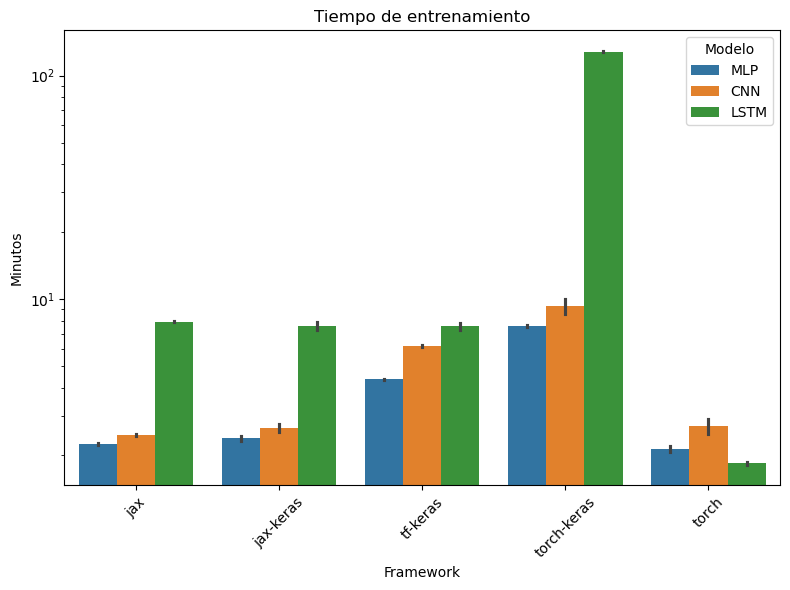

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=global_metrics_df,
    x="backend",
    y="training_time",
    hue="model_type",
    order=backend_order,
    hue_order=model_order,
    ax=ax,
    errorbar="sd"
)

ax.set_title("Tiempo de entrenamiento")
ax.set_xlabel("Framework")
ax.set_ylabel("Minutos")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(yscale="log")

legend = ax.legend(title='Modelo', loc='upper right' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())


plt.tight_layout()
plt.show()

/tmp/ipykernel_1744002/2300454992.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


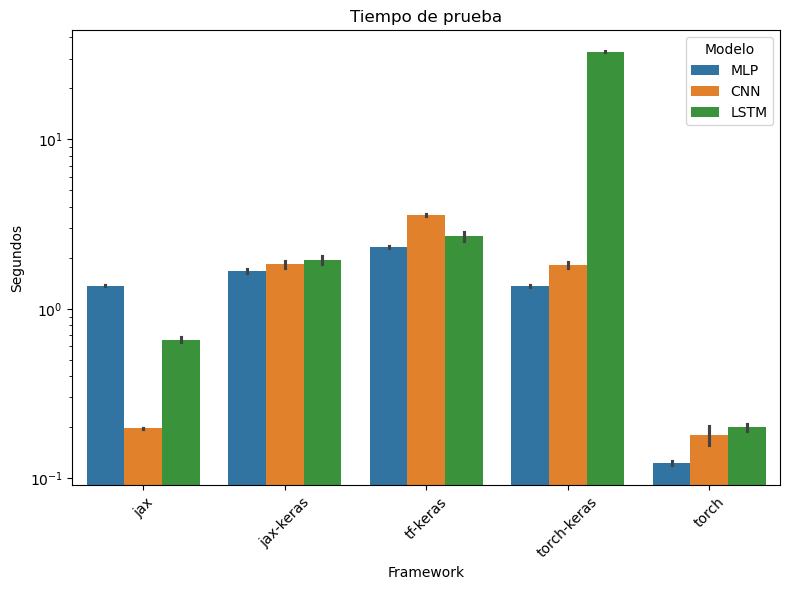

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))  # (1 fila, 2 columnas)

sns.barplot(
    data=global_metrics_df,
    x="backend",
    y="testing_time",
    hue="model_type",
    order=backend_order,
    hue_order=model_order,
    ax=ax,
    errorbar="sd"
)

ax.set_title("Tiempo de prueba")
ax.set_xlabel("Framework")
ax.set_ylabel("Segundos")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(yscale="log")

legend = ax.legend(title='Modelo', loc='upper right' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()

In [16]:
def get_stack_df(experiments, filename):
    # Almacenar los DataFrames de todas las semillas de una librería
    dfs = []

    for seed, files in experiments.items():
        if filename in files:
            dfs.append(files[filename])

    return pd.concat(dfs, axis=0)  # Stack de los DataFrames


def get_mean_df(df):
    return df.groupby(df.index).mean()  # Media fila a fila


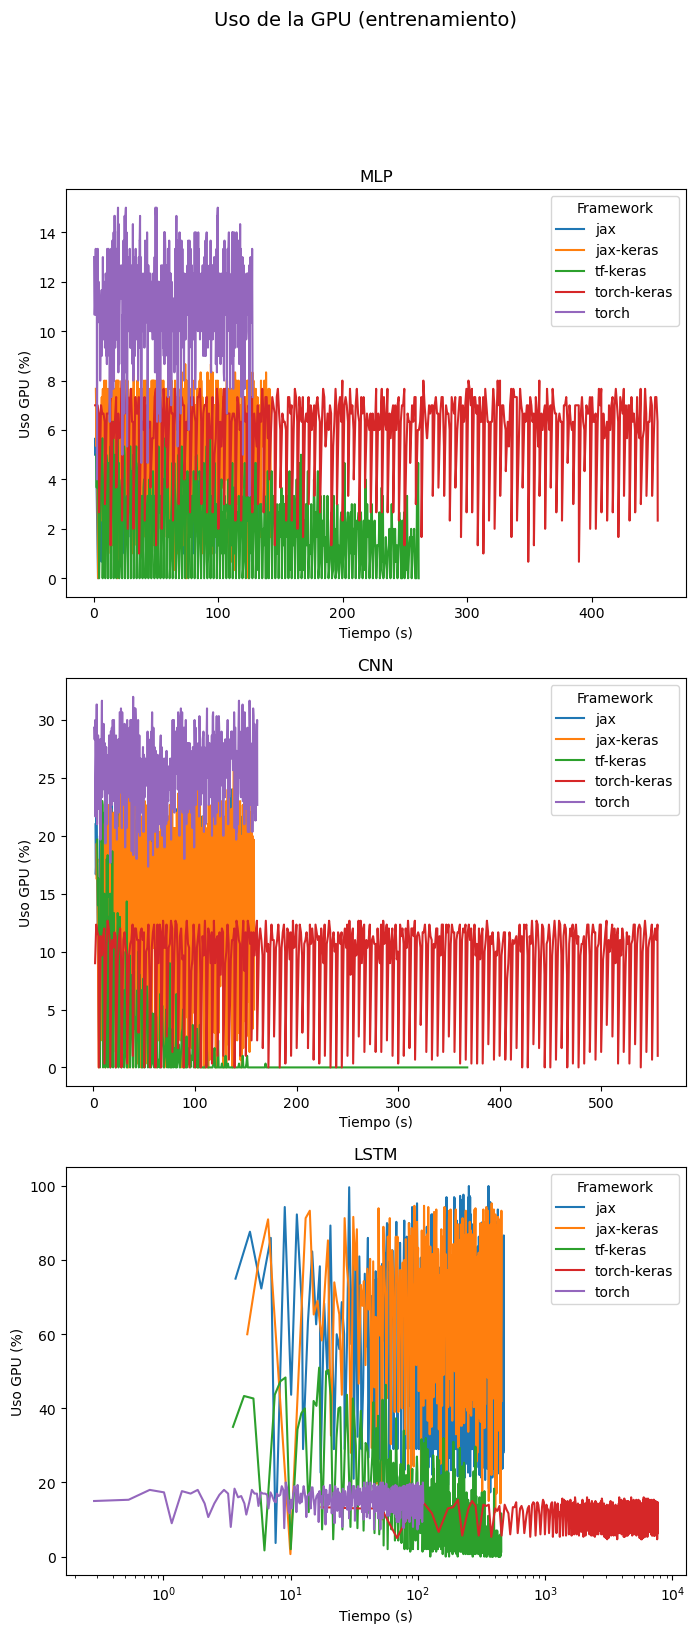

In [19]:
   
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

fig.suptitle("Uso de la GPU (entrenamiento)", fontsize=14)

for i, modelo in enumerate(resultados):
    ax = axes[i]
    for backend in backend_order:
        train_samples_df = get_mean_df(get_stack_df(resultados[modelo][backend], "train_samples"))
        
        sns.lineplot(
            data=train_samples_df,
            x="timestamp",
            y="gpu_0_utilization",
            ax=ax,
            label=backend
        )


    # Configuración de títulos y etiquetas
    ax.set_title(modelo.upper())
    ax.set_xlabel("Tiempo (s)")
    ax.set_ylabel("Uso GPU (%)")

# Agregar leyendas
    ax.legend(title="Framework")
    if modelo == "lstm":
        if i < 3:
            ax.set(xscale="log")
        else:
            ax.set(yscale="log")

# Mostrar la figura
plt.show()

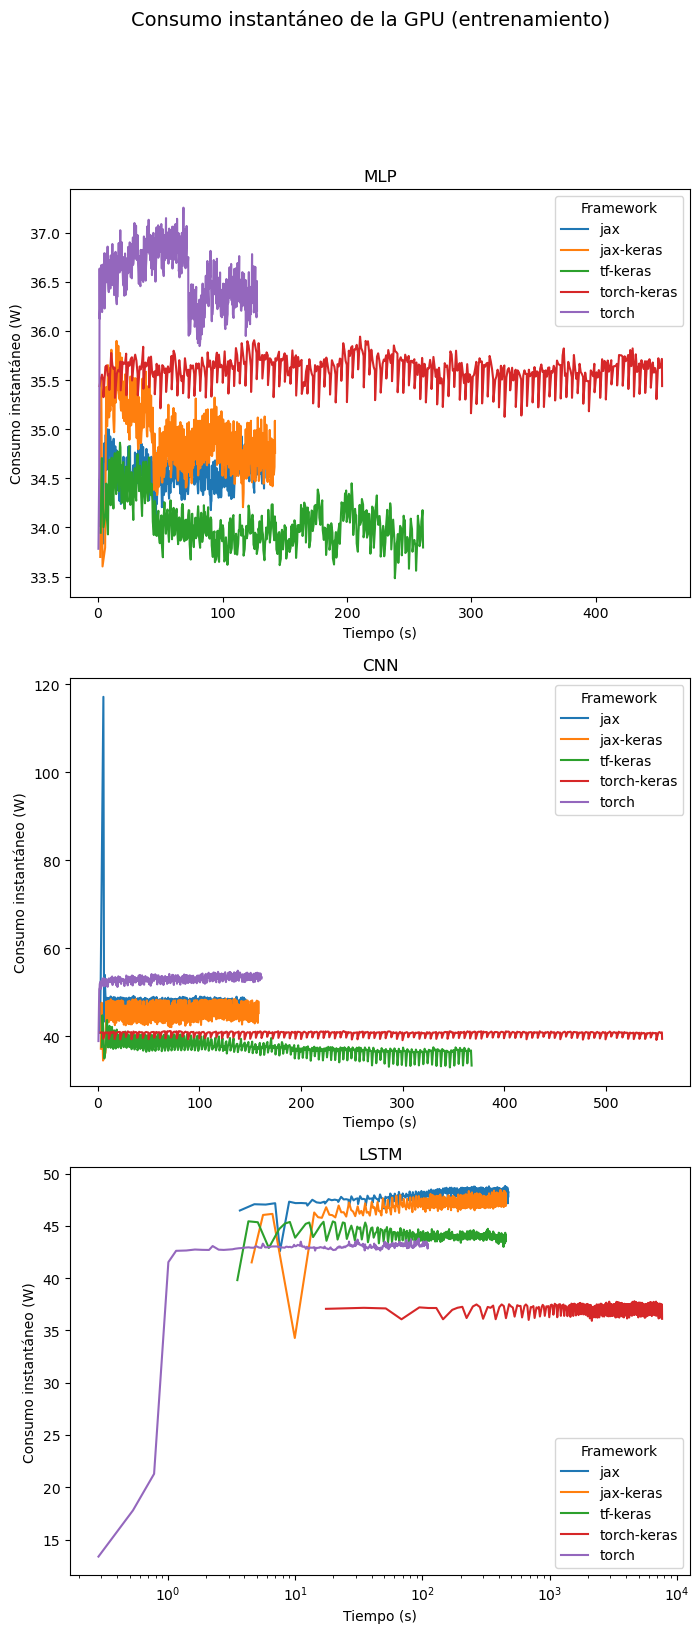

In [20]:
   
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

fig.suptitle("Consumo instantáneo de la GPU (entrenamiento)", fontsize=14)

for i, modelo in enumerate(resultados):
    ax = axes[i]
    for backend in backend_order:
        train_samples_df = get_mean_df(get_stack_df(resultados[modelo][backend], "train_samples"))
        
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_power", ax=ax, label=backend)


    # Configuración de títulos y etiquetas
    ax.set_title(modelo.upper())
    ax.set_xlabel("Tiempo (s)")
    ax.set_ylabel("Consumo instantáneo (W)")

# Agregar leyendas
    ax.legend(title="Framework")
    if modelo == "lstm":
        if i < 3:
            ax.set(xscale="log")
        else:
            ax.set(yscale="log")

# Mostrar la figura
plt.show()

/tmp/ipykernel_1744002/1927439052.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


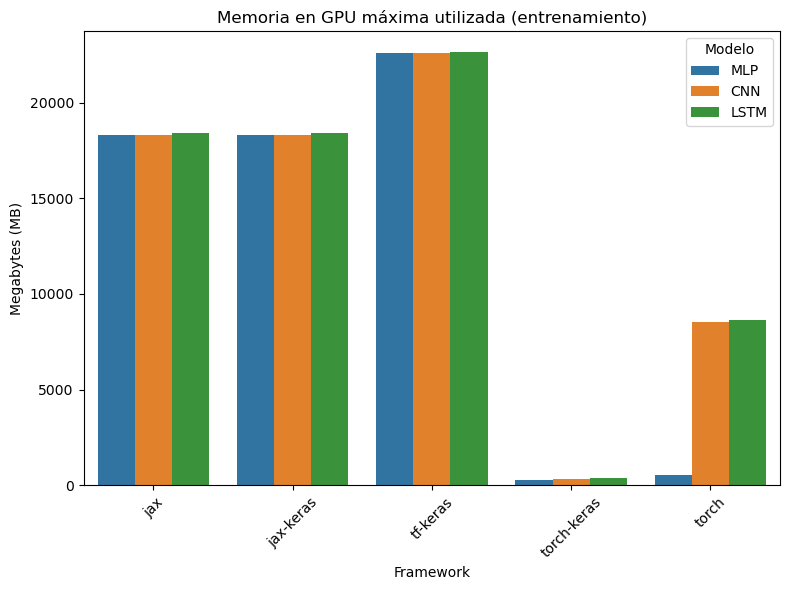

In [21]:
memory_dfs = []

for modelo, backends in resultados.items():
    for backend, semillas in backends.items():
        for seed, datos in semillas.items():
            
            if "train_samples" in datos:
                train_samples_df = datos["train_samples"].copy()
                df = pd.DataFrame({
                    "model_type": [modelo],
                    "framework": [backend],
                    "seed": [seed],
                    "memory_used": [train_samples_df["gpu_0_memory_used"].max()]
                })
                memory_dfs.append(df)
                
memory_df = pd.concat(memory_dfs, ignore_index=True)


fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=memory_df,
    x="framework",
    y="memory_used",
    hue="model_type",
    order=backend_order,
    hue_order=model_order,
    ax=ax,
    errorbar="sd"
)

ax.set_title("Memoria en GPU máxima utilizada (entrenamiento)")
ax.set_xlabel("Framework")
ax.set_ylabel("Megabytes (MB)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#ax.set(yscale="log")

legend = ax.legend(title='Modelo', loc='upper right' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()

In [22]:
# Julios = vatios * segundos
energia_dfs = []

for modelo, backends in resultados.items():
    for backend, semillas in backends.items():
        for seed, datos in semillas.items():

            # Ordenar por timestamp (por si acaso no lo estuviesen)
            df = datos["train_samples"].sort_values(by="timestamp").reset_index(drop=True)

            # Calcular delta_t (diferencia de tiempo entre muestras en segundos)
            df["delta_t"] = df["timestamp"].diff().fillna(0)

            # Calcular la energía consumida en cada intervalo (P * delta_t)
            df["energia"] = df["gpu_0_power"] * df["delta_t"]

            # Tiempo de entrenamiento
            tiempo = resultados[modelo][backend][seed]["global_metrics"]["training_time"].item()

            # Sumar toda la energía consumida
            energia_total = df["energia"].sum()

            energia_dfs.append({
                "modelo": modelo,
                "libreria": backend,
                "semilla": seed,
                "energia_total": energia_total / (1000 * 3600), # pasar de J a KWh
                "energia_hora": (energia_total / (1000)) / tiempo # J -> KW * s -> kWh/h
            })

energia_df = pd.DataFrame(energia_dfs)

/tmp/ipykernel_1744002/2125962207.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


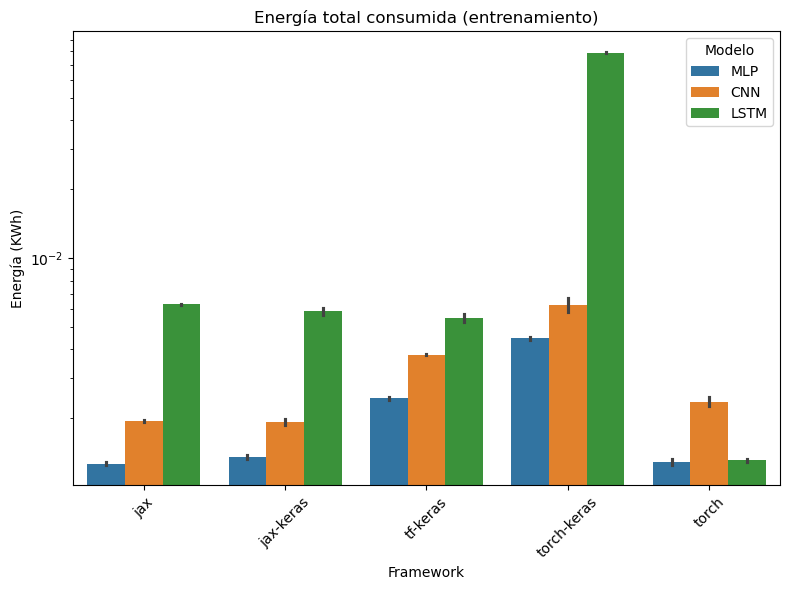

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=energia_df,
    x="libreria",
    y="energia_total",
    hue="modelo",
    order=backend_order,
    hue_order=model_order,
    ax=ax,
    errorbar="sd"
)

ax.set_title("Energía total consumida (entrenamiento)")
ax.set_xlabel("Framework")
ax.set_ylabel("Energía (KWh)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(yscale="log")

legend = ax.legend(title='Modelo', loc='upper right' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()


/tmp/ipykernel_1744002/1534678235.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


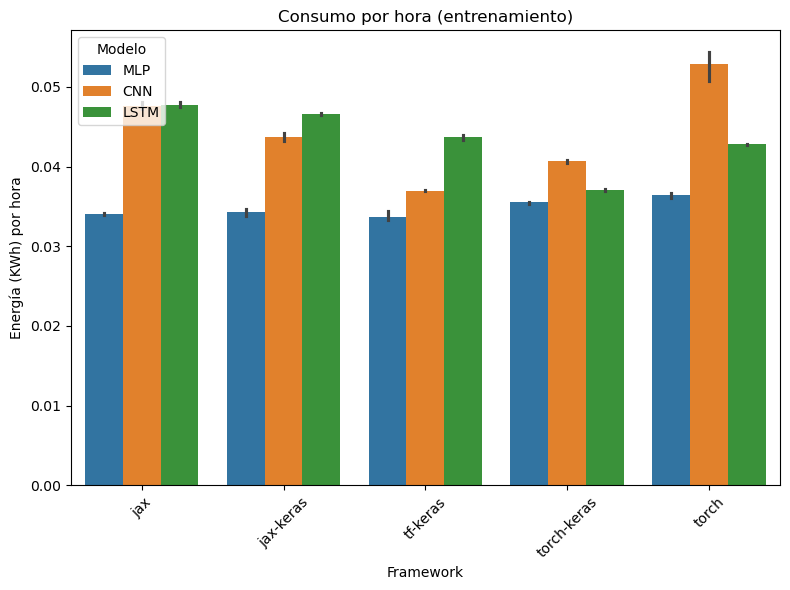

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=energia_df,
    x="libreria",
    y="energia_hora",
    hue="modelo",
    order=backend_order,
    hue_order=model_order,
    ax=ax
)

ax.set_title("Consumo por hora (entrenamiento)")
ax.set_xlabel("Framework")
ax.set_ylabel("Energía (KWh) por hora")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

legend = ax.legend(title='Modelo', loc='upper left' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()


In [25]:

all_test_results = []

for modelo in resultados:
    for backend in resultados[modelo]:
        for seed in resultados[modelo][backend]:
            test_df = resultados[modelo][backend][seed]["test"]
            test_df["model_type"] = modelo
            test_df["framework"] = backend
            test_df["seed"] = seed
            all_test_results.append(test_df)

test_results_df = pd.concat(all_test_results, ignore_index=True)

In [26]:
test_results_df.head(20)

,accuracy,loss,epoch_time,model_type,framework,seed,mae
0,0.9006,0.358843,2.153673,mlp,tf-keras,43,NaN
1,0.9002,0.370923,2.186323,mlp,tf-keras,44,NaN
2,0.8995,0.353044,2.189002,mlp,tf-keras,42,NaN
3,0.8954,1.566152,0.111472,mlp,torch,43,NaN
4,0.8912,1.569266,0.115845,mlp,torch,44,NaN
5,0.8879,1.572985,0.118284,mlp,torch,42,NaN
6,0.9011,0.345470,1.345182,mlp,torch-keras,43,NaN
7,0.9024,0.350847,1.381700,mlp,torch-keras,44,NaN
8,0.9031,0.336445,1.372895,mlp,torch-keras,42,NaN
9,0.9012,0.336415,1.691765,mlp,jax-keras,43,NaN


/tmp/ipykernel_1744002/911435666.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_1744002/911435666.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


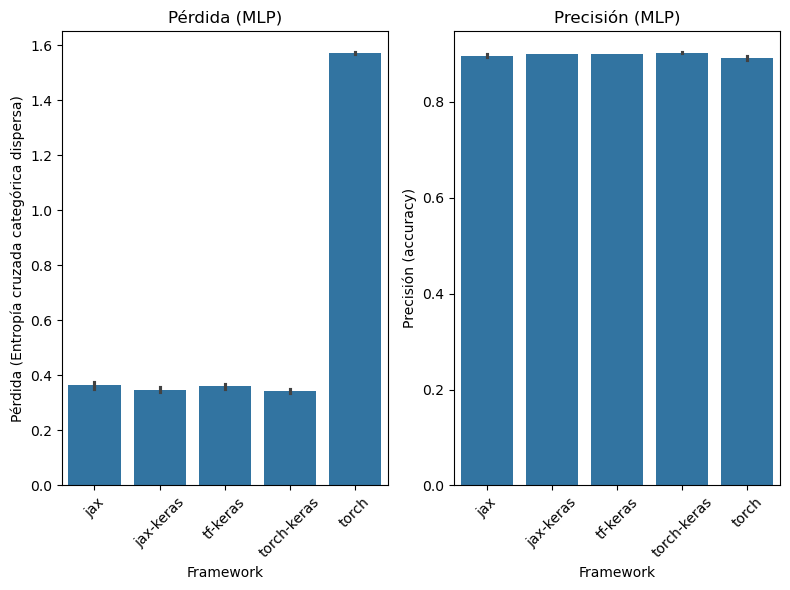

In [27]:
df = test_results_df[test_results_df["model_type"] == "mlp"]

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.barplot(
    data=df,
    x="framework",
    y="loss",
    hue="model_type",
    order=backend_order,
    hue_order=model_order,
    ax=axes[0],
    errorbar="sd"
)

axes[0].set_title("Pérdida (MLP)")
axes[0].set_xlabel("Framework")
axes[0].set_ylabel("Pérdida (Entropía cruzada categórica dispersa)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


sns.barplot(
    data=df,
    x="framework",
    y="accuracy",
    hue="model_type",
    order=backend_order,
    hue_order=model_order,
    ax=axes[1],
    errorbar="sd"
)

axes[1].set_title(f"Precisión (MLP)")
axes[1].set_xlabel("Framework")
axes[1].set_ylabel("Precisión (accuracy)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


for i, ax in enumerate(axes.flat):
    ax.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1744002/3210428288.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_1744002/3210428288.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


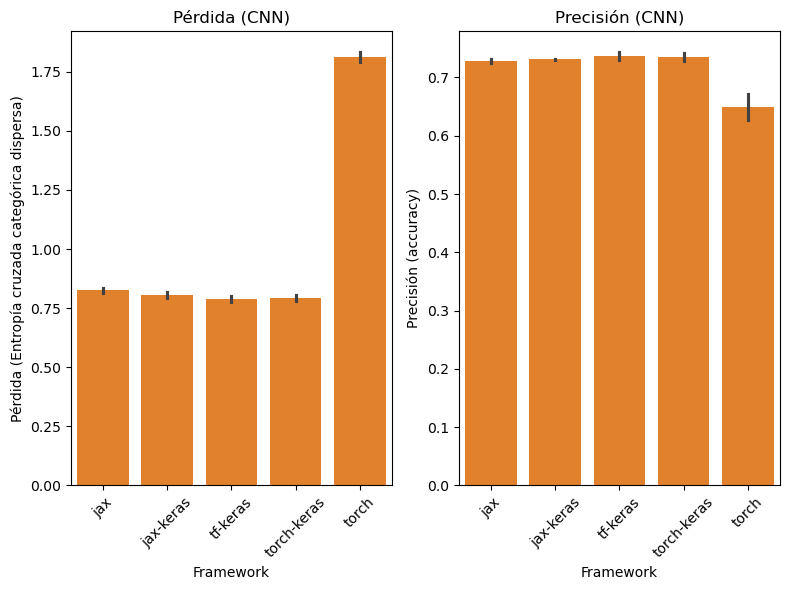

In [28]:

df = test_results_df[test_results_df["model_type"] == "cnn"]

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.barplot(
    data=df,
    x="framework",
    y="loss",
    hue="model_type",
    order=backend_order,
    hue_order=model_order,
    ax=axes[0],
    errorbar="sd"
)

axes[0].set_title("Pérdida (CNN)")
axes[0].set_xlabel("Framework")
axes[0].set_ylabel("Pérdida (Entropía cruzada categórica dispersa)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


sns.barplot(
    data=df,
    x="framework",
    y="accuracy",
    hue="model_type",
    order=backend_order,
    hue_order=model_order,
    ax=axes[1],
    errorbar="sd"
)

axes[1].set_title(f"Precisión (CNN)")
axes[1].set_xlabel("Framework")
axes[1].set_ylabel("Precisión (accuracy)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


for i, ax in enumerate(axes.flat):
    ax.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1744002/2141609963.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_1744002/2141609963.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


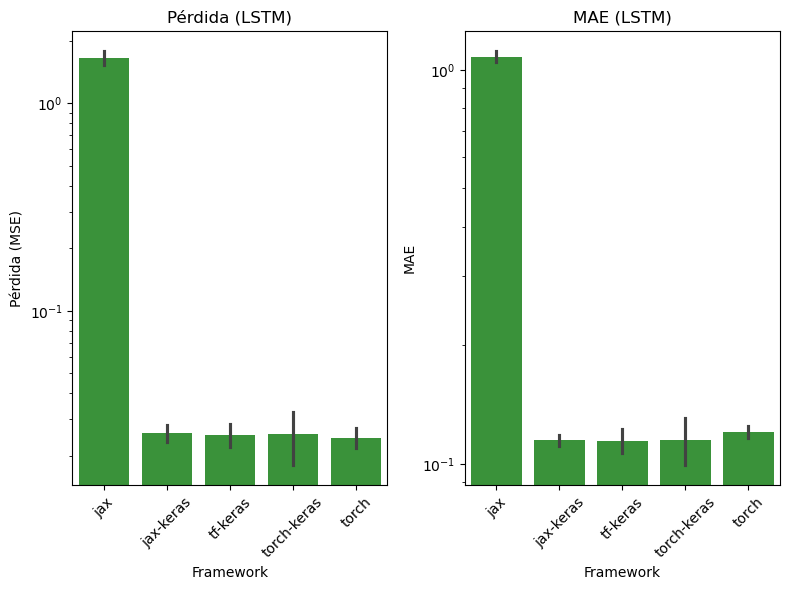

In [29]:

df = test_results_df[test_results_df["model_type"] == "lstm"]

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.barplot(
    data=df,
    x="framework",
    y="loss",
    hue="model_type",
    order=backend_order,
    hue_order=model_order,
    ax=axes[0],
    errorbar="sd"
)

axes[0].set_title("Pérdida (LSTM)")
axes[0].set_xlabel("Framework")
axes[0].set_ylabel("Pérdida (MSE)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


sns.barplot(
    data=df,
    x="framework",
    y="mae",
    hue="model_type",
    order=backend_order,
    hue_order=model_order,
    ax=axes[1],
    errorbar="sd"
)

axes[1].set_title("MAE (LSTM)")
axes[1].set_xlabel("Framework")
axes[1].set_ylabel("MAE")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


for i, ax in enumerate(axes.flat):
    ax.legend([],[], frameon=False)
    ax.set(yscale="log")

plt.tight_layout()
plt.show()